In [1]:
import os, json
import torch, os


dir = '/work/aa0238/a271125/logs_ray/vae_gmm_multi_objective_scan/version_56/interim_results'

In [53]:
for file in os.listdir(dir):
    if file.endswith('.json'):
        path = os.path.join(dir, file)
        try:
            with open(path, 'r') as f:
                data = json.load(f)
            if not isinstance(data, dict) or not data:  # Leer oder kein Dict
                print("⚠️ Leer/unklar:", file)
        except Exception as e:
            print("❌ Fehler in", file, "->", e)

        
for root, dirs, files in os.walk(dir):
    for file in files:
        if file.endswith('.ckpt'):
            path = os.path.join(root, file)
            try:
                ckpt = torch.load(path, map_location='cpu')
            except Exception as e:
                print("❌ Fehlerhafter Checkpoint:", path, "->", e)


/tmp/ipykernel_352724/2853001488.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(path, map_location='cpu')


❌ Fehlerhafter Checkpoint: /work/aa0238/a271125/logs_ray/vae_gmm_multi_objective_scan/version_53/vae_gmm_scan_v53/train_vae_791518bf_117_adapt_epochs=20,cat_end_value=0.0448,clustering_lr=0.0000,gmm_end_value=0.0058,gmm_epochs=50,kld_weight=0.0_2025-06-26_05-17-30/checkpoints/epoch=119-step=9245.ckpt -> PytorchStreamReader failed reading zip archive: failed finding central directory
❌ Fehlerhafter Checkpoint: /work/aa0238/a271125/logs_ray/vae_gmm_multi_objective_scan/version_53/vae_gmm_scan_v53/train_vae_0d41ef97_118_adapt_epochs=20,cat_end_value=0.0409,clustering_lr=0.0000,gmm_end_value=0.0069,gmm_epochs=50,kld_weight=0.0_2025-06-26_05-24-08/checkpoints/epoch=14-step=645.ckpt -> PytorchStreamReader failed reading zip archive: failed finding central directory


In [54]:
from ray.tune import ExperimentAnalysis

exp_dir = "/work/aa0238/a271125/logs_ray/vae_gmm_multi_objective_scan/version_53/"
analysis = ExperimentAnalysis(exp_dir)
for trial in analysis.trials:
    res = trial.last_result if hasattr(trial, "last_result") else {}
    if "silhouette" not in res:
        print(f"⚠️ Trial {trial.trial_id} fehlt silhouette!")


⚠️ Trial 10b0cc65 fehlt silhouette!
⚠️ Trial 51401cba fehlt silhouette!


Höchster Silhouette-Score: 0.12375909835100174


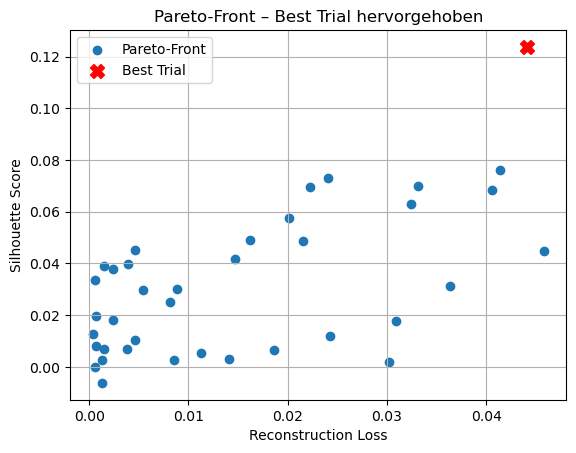

<Figure size 640x480 with 0 Axes>

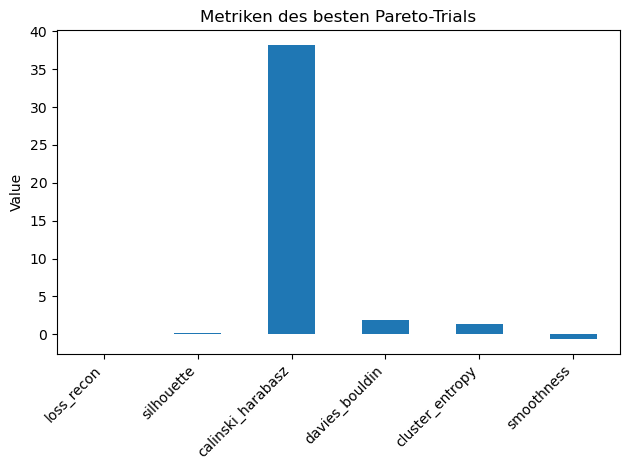

,Config Value
vae_lr,0.000988
clustering_lr,0.000028
recon_weight,0.197595
kld_weight,0.000044
gmm_end_value,0.007606
reg_end_value,0.119196
cat_end_value,0.002806
vae_lr_factor,0.758347
vae_lr_patience,30.000000
latent_dim,14.000000


In [25]:
import json
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt

# Pfade anpassen nach deinem Setup
metrics_dir = Path("/work/aa0238/a271125/logs_ray/vae_gmm_multi_objective_scan/version_56/interim_results")

#ids_metrics = [tf.stem.split("trial_")[1] for tf in metrics_dir.glob("trial_*.json")]

# %% Zell 3: Metrics-Dateien einlesen und mit Config koppeln
pareto = []
for tf in metrics_dir.glob("trial_*.json"):
    trial = json.loads(tf.read_text(encoding="utf-8"))
    config = trial['config']
    trial_id = trial['trial_id']
    metrics = trial['metrics']

    pareto.append({
        "trial_id": trial_id,
        "config": config,
        "metrics": metrics
    })


# %% Zell 4: DataFrame bauen und filtern
df = pd.DataFrame([
    { **t["config"], **t["metrics"] }
    for t in pareto
])


df_clean = df[(df["silhouette"] > -999) & (df["loss_recon"] < 999)]

df_clean.head()


# %% Zell 5: Best Trial nach Silhouette finden
best = max(pareto, key=lambda t: t["metrics"]["silhouette"])
best_metrics = best["metrics"]
print("Höchster Silhouette-Score:", best_metrics["silhouette"])


# %% Zell 6: Pareto-Front Scatter-Plot
plt.figure()
plt.scatter(
    df_clean['loss_recon'], df_clean['silhouette'],
    label='Pareto-Front'
)
plt.scatter(
    best_metrics['loss_recon'], best_metrics['silhouette'],
    marker='X', s=100, c='red', label='Best Trial'
)
plt.xlabel("Reconstruction Loss")
plt.ylabel("Silhouette Score")
plt.title("Pareto-Front – Best Trial hervorgehoben")
plt.legend()
plt.grid(True)
plt.show()


# %% Zell 7: Bar-Chart der Metriken des besten Trials
metrics_df = pd.DataFrame.from_dict(
    best_metrics, orient='index', columns=['Value']
)

plt.figure()
metrics_df.plot(kind='bar', legend=False)
plt.title("Metriken des besten Pareto-Trials")
plt.ylabel("Value")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# %% Zell 8: Konfig-DataFrame des besten Trials anzeigen
config_df = pd.DataFrame.from_dict(
    best["config"], orient='index', columns=['Config Value']
)
config_df


In [26]:
# %% Zell 1: Imports und Pfade
import json
from pathlib import Path
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Ordner mit deinen trial_*.json
metrics_dir = Path("/work/aa0238/a271125/logs_ray/"
                   "vae_gmm_multi_objective_scan/version_56/interim_results")

# Wurzel, unter der alle experiment_state-*.json liegen
logs_root = Path("/work/aa0238/a271125/logs_ray/"
                 "vae_gmm_multi_objective_scan/version_56")


In [27]:
# %% Zell 2: Debug – Verzeichnis prüfen
print("metrics_dir =", metrics_dir)
print("  exists?   ", metrics_dir.exists())
print("  is_dir?   ", metrics_dir.is_dir())
print("  Dateien:  ", sorted([p.name for p in metrics_dir.glob("trial_*.json")]))


metrics_dir = /work/aa0238/a271125/logs_ray/vae_gmm_multi_objective_scan/version_56/interim_results
  exists?    True
  is_dir?    True
  Dateien:   ['trial_027027bb.json', 'trial_04df2370.json', 'trial_0a0aae77.json', 'trial_0e2ea927.json', 'trial_11e02660.json', 'trial_15c69953.json', 'trial_19e203f3.json', 'trial_1a93ef87.json', 'trial_2607bd2d.json', 'trial_268e7e98.json', 'trial_3e313644.json', 'trial_405a6e02.json', 'trial_511714aa.json', 'trial_5944feae.json', 'trial_620ed502.json', 'trial_722ea4cc.json', 'trial_79c0aa73.json', 'trial_85d03b31.json', 'trial_885150eb.json', 'trial_88875051.json', 'trial_8aa30bfd.json', 'trial_8f317f26.json', 'trial_a1222a12.json', 'trial_a23ea624.json', 'trial_aa471d94.json', 'trial_ad443711.json', 'trial_b65c1647.json', 'trial_c338f2c1.json', 'trial_c64cd2eb.json', 'trial_cb1a77f7.json', 'trial_d12b0e07.json', 'trial_dce68a9b.json', 'trial_dd6dc801.json', 'trial_e0ead8fd.json', 'trial_e435471d.json', 'trial_f1019195.json', 'trial_f5d188e8.json',

In [28]:
# %% Zell 3: Alle Metrik-JSONs laden
trials = []
for p in metrics_dir.glob("trial_*.json"):
    tid = p.stem.split("trial_")[1]
    data = json.loads(p.read_text(encoding="utf-8"))
    trials.append({"trial_id": tid, **data})

print(f"Anzahl geladener Trials: {len(trials)}")


Anzahl geladener Trials: 38


In [29]:
df_clean

# Baue Kosten-Matrix: jede Zeile ein Trial, jede Spalte ein Ziel
cost_matrix = np.vstack([
    df_clean["loss_recon"].to_numpy(),
    -df_clean["silhouette"].to_numpy(),
    df_clean["davies_bouldin"].to_numpy(),
    -df_clean["calinski_harabasz"].to_numpy(),
    -df_clean["smoothness"].to_numpy(),
]).T

# Pareto‐Front berechnen
is_pareto = np.ones(len(cost_matrix), dtype=bool)
for i, c in enumerate(cost_matrix):
    if not is_pareto[i]:
        continue
    # Finde alle j, die von i dominiert werden
    dominated = np.all(cost_matrix <= c, axis=1) & np.any(cost_matrix < c, axis=1)
    is_pareto[dominated] = False

pareto_df = df_clean[is_pareto]
pareto_df

,vae_lr,clustering_lr,recon_weight,kld_weight,gmm_end_value,reg_end_value,cat_end_value,vae_lr_factor,vae_lr_patience,latent_dim,gmm_epochs,warmup_epochs,adapt_epochs,loss_recon,silhouette,calinski_harabasz,davies_bouldin,cluster_entropy,smoothness
3,0.000250,0.000031,0.150881,0.001950,0.009303,0.061460,0.011819,0.729276,30,40,80,25,15,0.036330,0.031233,12.350500,4.036983,1.601237,-0.650097
7,0.004210,0.000001,0.116003,0.000644,0.008454,0.078695,0.001837,0.703028,20,60,50,20,15,0.030170,0.002061,6.591897,5.290149,1.137970,-0.673603
13,0.000083,0.000040,0.069358,0.001023,0.006866,0.494859,0.040323,0.948827,10,50,50,20,15,0.018627,0.006524,5.923944,6.988860,1.559650,-0.667188
20,0.000043,0.000008,0.001928,0.000019,0.008252,0.100340,0.003057,0.772059,10,50,100,25,10,0.000567,0.000088,3.609516,6.889266,1.501285,-0.680162
23,0.000027,0.000005,0.004246,0.000018,0.008360,0.020174,0.003473,0.768660,10,30,100,25,10,0.001248,-0.006220,4.741165,5.808431,1.425683,-0.661963
24,0.000044,0.000010,0.051727,0.000231,0.009501,0.176700,0.011853,0.815669,20,70,80,30,20,0.014077,0.002922,3.989362,7.615615,1.506749,-0.679744
25,0.000080,0.000004,0.004489,0.000168,0.004046,0.299305,0.005233,0.918108,40,70,100,15,10,0.001321,0.002739,3.398133,7.001855,1.608838,-0.672080
26,0.000152,0.000003,0.096745,0.000614,0.006351,0.198203,0.002118,0.702474,20,60,50,20,15,0.024270,0.011957,6.809485,5.959334,1.582007,-0.659766
29,0.004303,0.000003,0.030084,0.000863,0.006295,0.188247,0.002171,0.844462,20,60,50,20,15,0.008507,0.002555,3.807283,7.291497,1.579072,-0.671352
32,0.000104,0.000067,0.198184,0.002716,0.009174,0.065984,0.011130,0.804412,40,40,150,30,15,0.045768,0.044631,16.493940,3.505474,1.592326,-0.639892


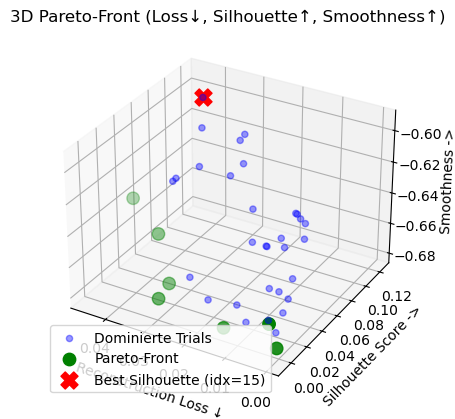

In [32]:
# %% Zell: Pareto‐Front und 3D‐Scatter für drei Ziele

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# Annahme: df_clean enthält die Spalten 'loss_recon', 'silhouette', 'smoothness'
loss = df_clean["loss_recon"].to_numpy()
sil  = df_clean["silhouette"].to_numpy()
sm   = df_clean["smoothness"].to_numpy()

# 1) Kosten‐Matrix: wir wollen alles minimieren → für Max-Ziele nehmen wir das Negative
cost_matrix = np.vstack([
    loss,        # minimieren
    -sil,        # maximieren → minimiere -silhouette
    -sm,         # maximieren → minimiere -smoothness
]).T  # shape (n_trials, 3)

# 2) Pareto‐Front berechnen (Non‐Domination)
is_pareto = np.ones(len(cost_matrix), dtype=bool)
for i, c in enumerate(cost_matrix):
    if not is_pareto[i]:
        continue
    # dominated: alle j für die cost_matrix[j] <= c in allen Zielen
    # und < c in mindestens einem
    dominated = np.all(cost_matrix <= c, axis=1) & np.any(cost_matrix < c, axis=1)
    is_pareto[dominated] = False

# 3) 3D‐Scatter zeichnen
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

# (a) dominierte Trials in hellgrau
ax.scatter(
    loss[~is_pareto],
    sil[~is_pareto],
    sm[~is_pareto],
    color="blue",
    alpha=0.4,
    label="Dominierte Trials"
)

# (b) Pareto‐Front in grün
ax.scatter(
    loss[is_pareto],
    sil[is_pareto],
    sm[is_pareto],
    color="green",
    s=80,
    label="Pareto‐Front"
)

# (c) Best‐Silhouette als rotes Kreuz
best_idx = sil.argmax()
ax.scatter(
    loss[best_idx],
    sil[best_idx],
    sm[best_idx],
    color="red",
    marker="X",
    s=150,
    label=f"Best Silhouette (idx={best_idx})"
)

# Labels und Titel
ax.set_xlabel("Reconstruction Loss ↓")
ax.set_ylabel("Silhouette Score ->")
ax.set_zlabel("Smoothness ->")
ax.set_title("3D Pareto‐Front (Loss↓, Silhouette↑, Smoothness↑)")

# Optional: X‐Achse invertieren, damit links kleinste Loss ist
ax.invert_xaxis()

ax.legend()
plt.show()


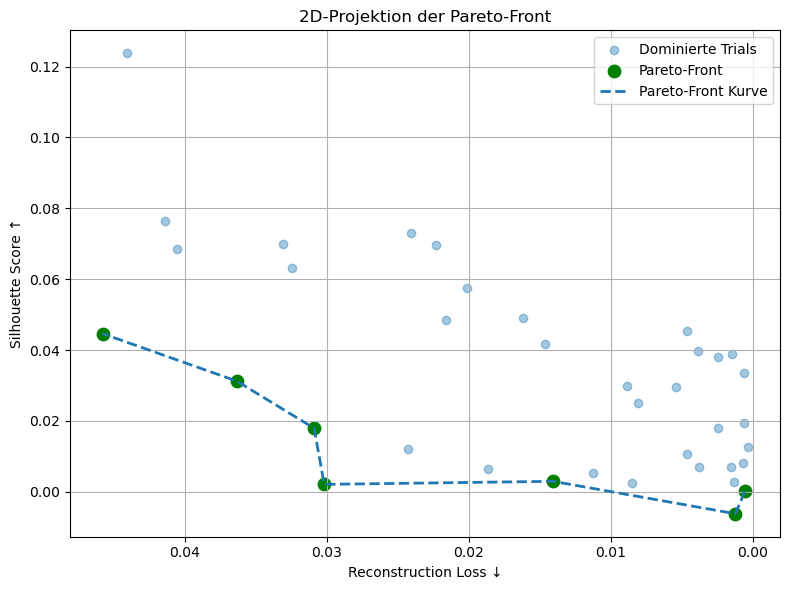

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Aus deinen vorhandenen Arrays:
# loss, sil, sm  (shape jeweils (n_trials,))
# is_pareto      (Boolean‐Array der Länge n_trials)

# 1) Wähle zwei Ziele für die 2D‐Visualisierung:
x = loss           # Reconstruction Loss (→ minimieren)
y = sil            # Silhouette Score (→ maximieren)

# 2) Scatterplot
plt.figure(figsize=(8, 6))

# a) Dominierte Trials
plt.scatter(
    x[~is_pareto],
    y[~is_pareto],
    alpha=0.4,
    label="Dominierte Trials"
)

# b) Pareto‐Front
plt.scatter(
    x[is_pareto],
    y[is_pareto],
    color="green",
    s=80,
    label="Pareto‐Front"
)

# 3) (Optional) Linie durch die Pareto‐Punkte
#    Sortiere erst nach x, damit die Linie nicht kreuzt
pareto_pts = np.vstack([x[is_pareto], y[is_pareto]]).T
pareto_sorted = pareto_pts[np.argsort(pareto_pts[:, 0])]
plt.plot(
    pareto_sorted[:, 0],
    pareto_sorted[:, 1],
    linestyle="--",
    linewidth=2,
    label="Pareto‐Front Kurve"
)

# 4) Achsen beschriften und invertieren (falls gewünscht)
plt.xlabel("Reconstruction Loss ↓")
plt.ylabel("Silhouette Score ↑")
plt.title("2D‐Projektion der Pareto‐Front")
plt.gca().invert_xaxis()   # damit links kleiner ist
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
